In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from glob import glob
import numpy as np
import nibabel as nib
import os
import pickle
from torch.utils.data import Dataset
from torchvision import transforms
from torch.autograd import Function, Variable
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
torch.cuda.get_device_name()

'Tesla P4'

In [0]:
def ELU(elu, nchan):
    if elu:
        return nn.ELU(inplace=True)
    else:
        return nn.PReLU(nchan)
    
def n_conv(nchan, depth, elu):
    layers = []
    for _ in range(depth):
        layers.append(single_conv(nchan, elu))
    return nn.Sequential(*layers)


class single_conv(nn.Module):
    def __init__(self, nchan, elu):
        super(single_conv, self).__init__()
        self.relu = ELU(elu, nchan)
        self.conv = nn.Conv3d(nchan, nchan, kernel_size=5, padding=2)
        self.bn = nn.BatchNorm3d(nchan)

    def forward(self, x):
        out = self.relu(self.bn(self.conv(x)))
        return out


In [0]:
class input_layer(nn.Module):
    def __init__(self, in_ch, out_ch, elu):
        super(input_layer, self).__init__()

        self.conv = nn.Conv3d(in_ch,out_ch,kernel_size=5,padding=2)
        self.relu = ELU(elu, out_ch)
        self.bn = nn.BatchNorm3d(out_ch)
        
    def forward(self, x):
        # 1. Convolve
        out = self.conv(x)
        # 2. Normalize
        out = self.bn(out)
        # 3. Add output and input
        out = torch.add(out, x)
        # 4. Activation
        out = self.relu(out)
        return out
    

In [0]:
class down_layer(nn.Module):
    def __init__(self, in_ch, nConv, elu):
        super(down_layer, self).__init__()
        out_ch = 2*in_ch
        self.down_conv = nn.Conv3d(in_ch, out_ch, kernel_size=2, stride=2)
        self.bn = nn.BatchNorm3d(out_ch)
        self.relu = ELU(elu, out_ch)
        self.layers = n_conv(out_ch, nConv, elu)
        
    def forward(self, x):
        down = self.relu(self.bn(self.down_conv(x)))
        out = self.layers(down)
        out = self.relu(torch.add(out, down))
        return down, out

In [0]:
class up_layer(nn.Module):
    def __init__(self, in_ch, out_ch, nConv, elu):
        super(up_layer, self).__init__()
        self.up_conv = nn.ConvTranspose3d(in_ch, out_ch//2 , kernel_size=2, stride=2)
        self.bn = nn.BatchNorm3d(out_ch//2 )
        self.relu1 = ELU(elu, out_ch//2 )
        self.relu2 = ELU(elu, out_ch)
        self.layers = n_conv(out_ch, nConv, elu)

    def forward(self, x, skipx):
        out = self.relu1(self.bn(self.up_conv(x)))
        xcat = torch.cat((out, skipx), 1)
        out = self.layers(xcat)
        out = self.relu2(torch.add(out, xcat))
        return out

In [0]:
class output_layer(nn.Module):
    def __init__(self, in_ch, elu, nll):
        super(output_layer, self).__init__()
        self.conv1 = nn.Conv3d(in_ch, 2, kernel_size=5, padding=2)
        self.bn = nn.BatchNorm3d(2)
        self.conv2 = nn.Conv3d(2, 1, kernel_size=1)
        self.relu1 = ELU(elu, 2)
        if nll:
            self.softmax = F.log_softmax
        else:
            self.sigmoid = F.sigmoid

    def forward(self, x):
        out = self.relu1(self.bn(self.conv1(x)))
        out = self.conv2(out)
        out = self.sigmoid(out)
        return out


In [0]:
class VNet(nn.Module):
    
    def __init__(self, elu=True, nll=False):
        super(VNet, self).__init__()
        #In
        self.input = input_layer(1, 16, elu)
        
        #Down
        self.down32 = down_layer(16, 1, elu)
        self.down64 = down_layer(32, 2, elu)
        self.down128 = down_layer(64, 3, elu)
        self.down256 = down_layer(128, 2, elu)
        
        #Up
        self.up256 = up_layer(256,256, 2, elu)
        self.up128 = up_layer(256,128, 2, elu)
        self.up64 = up_layer(128,64, 1, elu)
        self.up32 = up_layer(64,32, 1, elu)
        
        #Out
        self.output = output_layer(32, elu, nll)
    
    def forward(self, x):
        out16 = self.input(x)
        d_32, out32 = self.down32(out16)
        d_64, out64 = self.down64(out32)
        d_128, out128 = self.down128(out64)      
        d_256, out256 = self.down256(out128)
        output = self.up256(out256, out128)
        output = self.up128(output, out64)
        output = self.up64(output, out32)
        output = self.up32(output, out16)
        output = self.output(output)
        return output

In [0]:
# Path to the folder that contains folders of segmentation data
train_path = "data/Preprocessed/train/*/"
test_path = "data/Preprocessed/test/*/"
val_path = "data/Preprocessed/validation/*/"

train_image_mask_paths = []
test_image_mask_paths = []
val_image_mask_paths = []

block_size = (32,32,32)

#Load training images
directory_paths = glob(train_path)
for path in directory_paths:
    # Load all the paths for each Flair set of data (1 Flair data and all its segmentation paths)
    flair_path = path + 'FLAIR_preprocessed.nii.gz'
    seg_path = path + 'Consensus.nii.gz'
    train_image_mask_paths.append((flair_path,seg_path))
    
directory_paths = glob(test_path)
for path in directory_paths:
    # Load all the paths for each Flair set of data (1 Flair data and all its segmentation paths)
    flair_path = path + 'FLAIR_preprocessed.nii.gz'
    seg_path = path + 'Consensus.nii.gz'
    test_image_mask_paths.append((flair_path,seg_path))
    
directory_paths = glob(val_path)
for path in directory_paths:
    # Load all the paths for each Flair set of data (1 Flair data and all its segmentation paths)
    flair_path = path + 'FLAIR_preprocessed.nii.gz'
    seg_path = path + 'Consensus.nii.gz'
    val_image_mask_paths.append((flair_path,seg_path))


In [0]:
def zero_padding(data, block_size):
    # Calculate final size to be achieved
    ceil_val = math.ceil(data.shape[0]/block_size[0])
    #Calculate required padding size 
    pad_val_c = (block_size[0] * ceil_val) - data.shape[0]
    
    # Calculate final size to be achieved
    ceil_val = math.ceil(data.shape[1]/block_size[1])
    #Calculate required padding size
    pad_val_h = (block_size[1] * ceil_val) - data.shape[1]
    
    # Calculate final size to be achieved
    ceil_val = math.ceil(data.shape[2]/block_size[2])
    # Calculate required padding size
    pad_val_w = (block_size[2] * ceil_val) - data.shape[2]
    
    # Constant padding
    data = np.pad(data, ((0,pad_val_c),(0,pad_val_h),(0,pad_val_w)), 'constant')
    #data = np.array(data, dtype=np.int16)
    
    #changed dtype to float
    data = np.array(data, dtype=np.float32)
    return data


def get_data_blocks(data, block_size ):
    x = torch.from_numpy(data)
    # Add a dimension at 0th position
    x = x.unsqueeze(0)
    # Kernel Size
    kc, kh, kw = block_size[0], block_size[1], block_size[2]
    # stride
    dc, dh, dw = block_size[0], block_size[1], block_size[2]
    patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
    unfold_shape = patches.size()
    patches = patches.contiguous().view(patches.size(0), -1, kc, kh, kw)
    #Return Patches and Unfold Shape
    return patches, unfold_shape

In [0]:
def preprocess_image(image_mask_paths):
    img_mask_list = []

    for i in tqdm(range(len(image_mask_paths))):
        
        #load the img and mask
        vol = nib.load(image_mask_paths[i][0])
        m = nib.load(image_mask_paths[i][1])
        
        # Get data, normalize the image and pad
        img = np.array(vol.get_data(), np.float32)
        img = img / np.amax(img)
        img_padded = zero_padding(img, block_size)
        
        mask = np.array(m.get_data(),np.uint8)
        mask = mask / np.amax(mask)
        mask_padded = zero_padding(mask, block_size)

        # Generate data blocks of block_size
        img_blocks, unfold_shape_img = get_data_blocks(data = img_padded, block_size = block_size)
        mask_blocks, unfold_shape_mask = get_data_blocks(data = mask_padded, block_size = block_size)

        img_array = img_blocks.numpy()
        mask_array = mask_blocks.numpy()

        for i in range(len(img_array[0])):
            if np.sum(mask_array[0][i]) > 0:
                img_mask_list.append((img_array[0][i], mask_array[0][i]))

    return img_mask_list 

In [0]:
#Training:
train_img_masks = preprocess_image(train_image_mask_paths)

#Training:
test_img_masks = preprocess_image(test_image_mask_paths)

#Validation:
val_img_masks = preprocess_image(val_image_mask_paths)

print('No. of blocks containing lesion: ',len(train_img_masks))

100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

No. of blocks containing lesion:  536


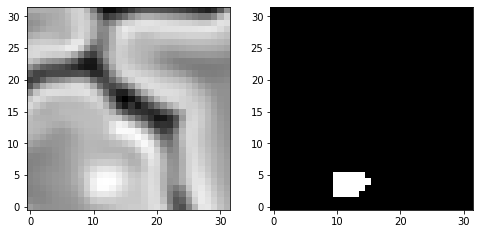

In [0]:
#Image and mask alignment

def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices), figsize=(8,8))
    for i, slc in enumerate(slices):
        axes[i].imshow(slc.T, cmap="gray", origin="lower")

# display all slices of an image block
# for i in range(1):
#     for j in range(2):
#         show_slices([train_img_masks[i][0][: ,j, :], train_img_masks[i][1][:, j, :]])

# Display one slice of the image block
show_slices([train_img_masks[0][0][31 ,:, :], train_img_masks[0][1][31 , :, :]])

In [0]:
# Test the max value of one training image and mask
print('Input image max value: ',np.amax(train_img_masks[0][0]))
print('Input mask max value: ',np.amax(train_img_masks[0][1]))

Input image max value:  0.40416786
Input mask max value:  1.0


In [0]:
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        image, label = sample['img'], sample['label']
        image = image[None,:,:]
        label = label[None,:,:]

        return {'img': torch.from_numpy(image.copy()).type(torch.FloatTensor),
                'label': torch.from_numpy(label.copy()).type(torch.FloatTensor)}

In [0]:
class CustomDataset(Dataset):
    def __init__(self, image_masks, transforms=None):

        self.image_masks = image_masks
        self.transforms = transforms

    def __len__(self):  # return count of sample we have

        return len(self.image_masks)

    def __getitem__(self, index):

        image = self.image_masks[index][0] # H, W, C
        mask = self.image_masks[index][1]

#       image = np.transpose(image, axes=[2, 0, 1]) # C, H, W

        sample = {'img': image, 'label': mask}

        if transforms:
            sample = self.transforms(sample)

        return sample

train_dataset = CustomDataset(train_img_masks, transforms=transforms.Compose([ToTensor()]))
val_dataset = CustomDataset(val_img_masks, transforms=transforms.Compose([ToTensor()]))

In [0]:
# dice coefficient 
class DiceCoeff(Function):
  """Dice coeff for one pair of input image and target image"""
  def forward(self, prediction, target):
    self.save_for_backward(prediction, target)
    eps = 0.0001 
    A = prediction.view(-1)
    B = target.view(-1)
    inter = torch.dot(A.float(),B.float())
    union = torch.sum(A.float()) + torch.sum(B.float()) - inter + eps
    d = inter / union
    #print('d: ',d)
    return d

#dice coefficients for batches
def dice_coeff(prediction, target):
  """Dice coeff for batches"""
  s = torch.FloatTensor(1).zero_()

  for i, (a,b) in enumerate(zip(prediction, target)):
      s += DiceCoeff().forward(a,b)
  s = s / (i + 1)
  return s


In [0]:
class DiceLoss(nn.Module):
  def __init__(self):
    super(DiceLoss, self).__init__()
    self.smooth = 1.0

  def forward(self, y_pred, y_true):
    assert y_pred.size() == y_true.size()
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    intersection = (y_pred * y_true).sum()
    dsc = (2. * intersection + self.smooth) / (
        y_pred.sum() + y_true.sum() + self.smooth
    )
    return 1. - dsc

def dice_loss(prediction, target):
  """Dice coeff for batches"""
  s = torch.FloatTensor(1).zero_()

  for i, (a,b) in enumerate(zip(prediction, target)):
      s += DiceLoss().forward(a,b)
  s = s / (i + 1)
  return s

In [0]:
def eval_net(net, dataset):
    # set net mode to evaluation
    net.eval()
    tot = 0
    for i, b in enumerate(dataset):
        img = b['img'].to(device)
        B = img.shape[0]
        true_mask = b['label'].to(device)

        # Feed the image to the network to get predicted mask
        mask_pred = net.forward(img.float())
        
        # For all pixels in predicted mask, set them to 1 if larger than 0.5. Otherwise set them to 0
        mask_pred = mask_pred > 0.5
        
        tot += dice_coeff(true_mask,mask_pred)
    return tot / (i + 1)


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
net = VNet(elu=False, nll=False)
#print(model)

In [0]:
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

Number of parameters in network:  45603451


In [0]:
from torch import optim
epochs = 200 # e.g. 10, or more until dice converge
batch_size = 16 # e.g. 16
lr = 0.1        # e.g. 0.01, 0.00001
N_train = len(train_img_masks)
model_save_path = 'models/vnet/'  # directory to same the model after each epoch.

optimizer = optim.Adam(net.parameters(),lr = lr, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma=0.1)

criterion = nn.BCELoss()
net.to(device)
results = []
# Start training
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    net.train()
    # Reload images and masks for training and validation and perform random shuffling at the begining of each epoch
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=10)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=10)

    epoch_loss = 0
    count = 0
    print('train len: ', len(train_loader))

    for i, b in enumerate(train_loader):
        # Get images and masks from each batch
        imgs = b['img']
        true_masks = b['label']
        
        imgs = imgs.to(device)
        true_masks = true_masks.to(device)

        # Feed images into the network
        masks_pred = net.forward(imgs.float())
        
        true_masks_flat = true_masks.view(-1)
        masks_pred_flat = masks_pred.view(-1)

        # Calculate the loss by comparing the predicted masks vector and true masks vector
        loss = dice_loss(masks_pred_flat,true_masks_flat)
        epoch_loss += loss.item()

        if count % 50 == 0:
            print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item()))
        count = count + 1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch finished ! Loss: {}'.format(epoch_loss / (i+1)))
    results.append((epoch, epoch_loss/(i+1)))
    # Perform validation with eval_net() on the validation data
    val_dice = eval_net(net,val_loader)
    print('Validation Dice Coeff: {}'.format(val_dice))
    scheduler.step()
    
    if epoch%20 == 19:
      # Save the model after each epoch
      if os.path.isdir(model_save_path):
          torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
      else:
          os.makedirs(model_save_path, exist_ok=True)
          torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
      print('Checkpoint {} saved !'.format(epoch + 1))


Starting epoch 1/200.
train len:  34
0.0000 --- loss: 0.936638
Epoch finished ! Loss: 0.8168823052855099
Validation Dice Coeff: tensor([0.0093])
Starting epoch 2/200.
train len:  34
0.0000 --- loss: 0.811543
Epoch finished ! Loss: 0.6924081094124738
Validation Dice Coeff: tensor([0.0231])
Starting epoch 3/200.
train len:  34
0.0000 --- loss: 0.779841
Epoch finished ! Loss: 0.6472185219035429
Validation Dice Coeff: tensor([0.0107])
Starting epoch 4/200.
train len:  34
0.0000 --- loss: 0.376216
Epoch finished ! Loss: 0.6535194007789388
Validation Dice Coeff: tensor([0.0219])
Starting epoch 5/200.
train len:  34
0.0000 --- loss: 0.613266
Epoch finished ! Loss: 0.6441544942996081
Validation Dice Coeff: tensor([0.0867])
Starting epoch 6/200.
train len:  34
0.0000 --- loss: 0.765537
Epoch finished ! Loss: 0.6390678304083207
Validation Dice Coeff: tensor([0.0158])
Starting epoch 7/200.
train len:  34
0.0000 --- loss: 0.576926
Epoch finished ! Loss: 0.6030667669632855
Validation Dice Coeff: te

In [0]:
# net.load_state_dict(torch.load('models/vnet_final/Brain_Seg_Epoch200.pth'))
# net.to(device)

VNet(
  (input): input_layer(
    (conv): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (relu): PReLU(num_parameters=16)
    (bn): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down32): down_layer(
    (down_conv): Conv3d(16, 32, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): PReLU(num_parameters=32)
    (layers): Sequential(
      (0): single_conv(
        (relu): PReLU(num_parameters=32)
        (conv): Conv3d(32, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
        (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (down64): down_layer(
    (down_conv): Conv3d(32, 64, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): PReLU(num_parameters=64)
    (layers

In [0]:
x = []
y = []
for i in range(len(results)):
    x.append(results[i][0])
    y.append(results[i][1])

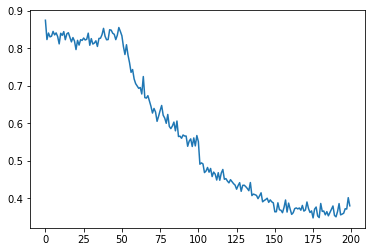

In [0]:
plt.plot(x,y)

In [0]:
def predict_img(net,full_img,out_threshold=0.5):
    # set the mode of your network to evaluation
    net.eval()

    X_img = torch.from_numpy(full_img).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        output_img = net(X_img.float())
        out_probs = output_img.squeeze(0).squeeze(0)
        out_mask_np = (out_probs>out_threshold).cpu().numpy().astype('uint8')

    return out_mask_np

In [0]:
def reconstruct(blocks, unfold_shape):

    blocks_orig = blocks.view(unfold_shape)
    output_c = unfold_shape[1] * unfold_shape[4]
    output_h = unfold_shape[2] * unfold_shape[5]
    output_w = unfold_shape[3] * unfold_shape[6]
    blocks_orig = blocks_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
    blocks_orig = blocks_orig.view(1, output_c, output_h, output_w)
    # Remove the dimension at 0th position and convert to numpy
    blocks_orig = blocks_orig.squeeze(0).detach().numpy()
    return blocks_orig

In [0]:
mask_pred = predict_img(net=net,full_img=train_img_masks_1[0][0], out_threshold=0.5)

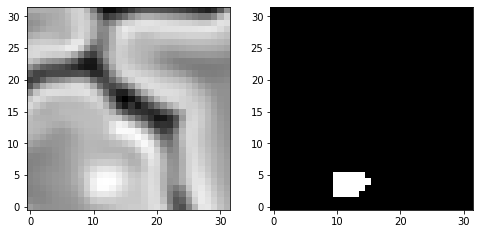

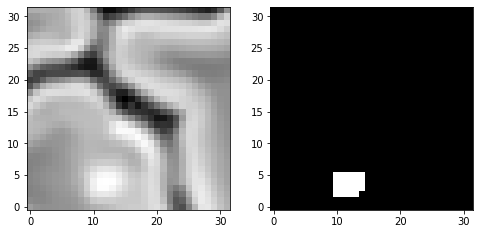

In [0]:
show_slices([train_img_masks[0][0][31,:,:], train_img_masks[0][1][31,:,:]])
show_slices([train_img_masks[0][0][31,:,:], mask_pred[31,:,:]])


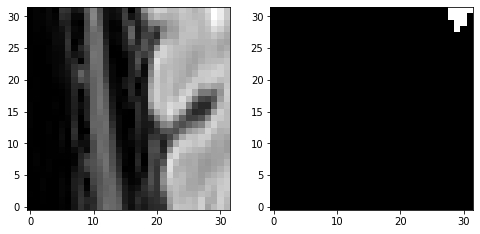

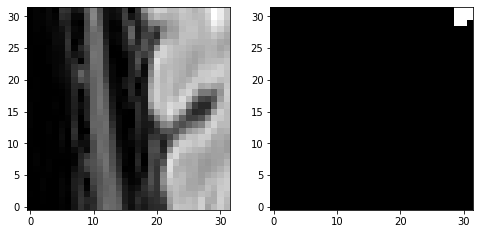

In [0]:
show_slices([train_img_masks[0][0][:,:,17], train_img_masks[0][1][:,:,17]])
show_slices([train_img_masks[0][0][:,:,17], mask_pred[:,:,17]])


In [0]:
# Load an image from testing dataset
test_img_paths = "data/test/01042GULE/3DFLAIR.nii.gz"
test_mask_paths = "data/test/01042GULE/Consensus.nii.gz"

vol = nib.load(test_img_paths)
m = nib.load(test_mask_paths)

img = np.array(vol.get_data(), np.float32) 
img = img/np.amax(img)
img_padded = zero_padding(img, block_size)

mask_orig = np.array(m.get_data(),np.uint8)
mask_orig = mask_orig/np.amax(mask_orig)
mask_padded = zero_padding(mask_orig, block_size)

# Generate data blocks of block_size
img_blocks, unfold_shape_img = get_data_blocks(data = img_padded, block_size = block_size)
mask_blocks, unfold_shape_mask = get_data_blocks(data = mask_padded, block_size = block_size)

print(img_blocks.shape)
    

torch.Size([1, 1280, 32, 32, 32])


In [0]:
img_array = img_blocks.numpy()
mask_array = mask_blocks.numpy()
test_img = []
lesions = []

for i in range(len(img_array[0])):
    test_img.append(img_array[0][i])

predicted = []
for image in test_img:

    # Predict the mask
    mask_pred = predict_img(net=net,full_img=image, out_threshold=0.5)
    predicted.append(mask_pred)

pred = torch.from_numpy(np.asarray(predicted)).type(torch.FloatTensor)

In [0]:
mask_recon = reconstruct(pred,unfold_shape_mask)

In [0]:
#Segmentation
mask_recon = torch.from_numpy(mask_recon).type(torch.FloatTensor)
mask_interpolated = nn.functional.interpolate(mask_recon.unsqueeze(0).unsqueeze(0), size=mask_orig.shape, mode='trilinear')
img_seg = mask_interpolated * img
img_seg = img_seg.squeeze().squeeze().numpy()
img_seg_original = mask_orig * img

Text(0.5, 0.98, 'Center slices for MRI image')

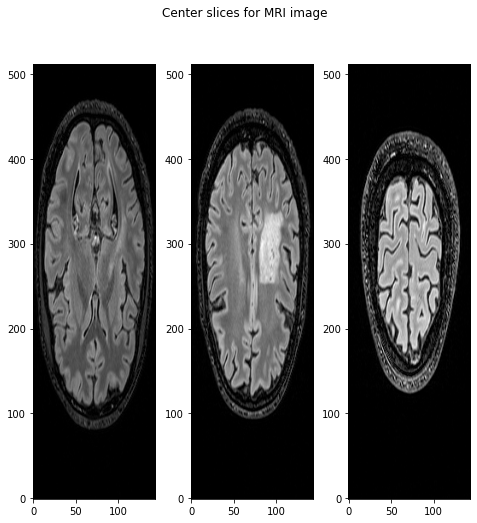

In [0]:
slice_0 = img[:, :, 300]
slice_1 = img[:, :, 350]
slice_2 = img[:, :, 400]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for MRI image")

Text(0.5, 0.98, 'Center slices for MRI image segmented original')

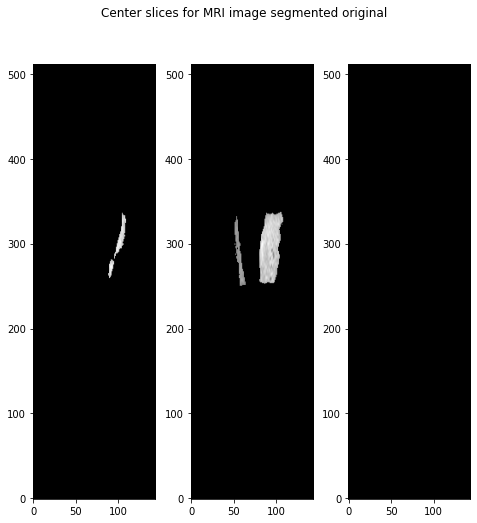

In [0]:
slice_0 = img_seg_original[:, :, 300]
slice_1 = img_seg_original[:, :, 350]
slice_2 = img_seg_original[:, :, 400]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for MRI image segmented original")

Text(0.5, 0.98, 'Center slices for MRI image segmented by prediction')

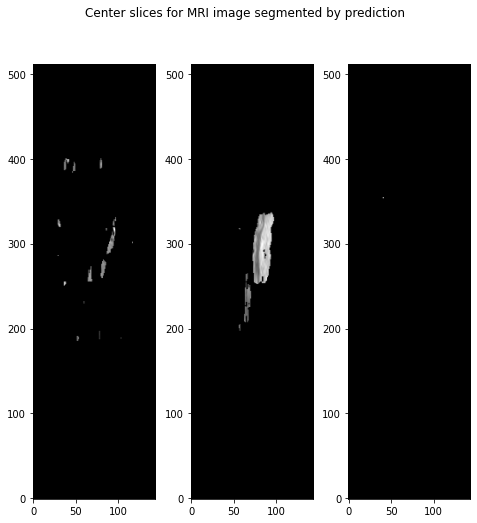

In [0]:
slice_0 = img_seg[:, :, 300]
slice_1 = img_seg[:, :, 350]
slice_2 = img_seg[:, :, 400]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for MRI image segmented by prediction")